Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
X, y = load_digits(n_class=10, return_X_y=True)

In [3]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

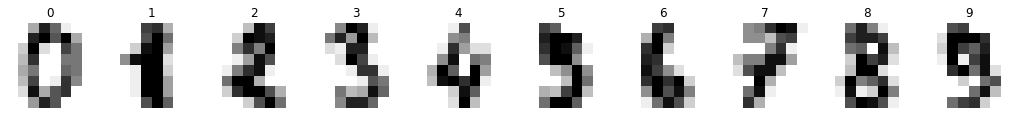

In [4]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)
    ax.set_title(label)

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from sklearn.metrics import pairwise_distances, silhouette_score, v_measure_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from numpy.random import RandomState

In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.labels_ = None
        self.cluster_centers_ = None
        self.objective_ = None
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        distances = pairwise_distances(X, cluster_centers,metric='euclidean')
        return distances
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        new_centroids = pd.DataFrame(X).groupby(by=nearest_clusters).mean().values 
        #print(f'fresh centroids:\n {new_centroids}')
        return new_centroids
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        if X.shape[0] >= self.n_clusters:
            all_clusters = np.zeros((self.n_init, X.shape[0])) 
            all_centroids = np.zeros((self.n_clusters,X.shape[1],self.n_init))
            objectives = np.zeros(self.n_init)

            for i in range(self.n_init):    
                centroid_indices = np.random.choice(X.shape[0]-1, size=self.n_clusters, replace=False)
                centroids = X[centroid_indices, :].copy()
               # print(f'centroids: \n{centroids}')
                nearest_clusters = np.zeros(X.shape[0])

                for _ in range(self.max_iter):
                    distances = self.calculate_distances_to_centroids(X, centroids)
                    #print(f'distances:\n {distances}')
                    nearest_clusters = distances.argmin(axis=1) 
                    #print(f'clusters:\n {nearest_clusters}')
                    new_centroids = np.array(centroids, dtype='float64')
                    computed_centroids = self.update_centroids(X, nearest_clusters)
                    for cl in np.unique(nearest_clusters):
                        #print(f'cl: {cl}')
                        new_centroids[cl,:] = computed_centroids[cl,:]
            
                   # print(f'new centroids:\n {new_centroids}')
                    if np.count_nonzero(centroids - new_centroids) == 0:        
                        break     
                    else:        
                        centroids = new_centroids  
                #print('calc obj')
                all_clusters[i,:] = nearest_clusters
                all_centroids[:,:,i] = centroids
                objectives[i] = self.objective(X,nearest_clusters,centroids)

            best_L_ind = objectives.argmin()
            self.labels_ = all_clusters[best_L_ind,:]
            self.cluster_centers_ = all_centroids[:,:,best_L_ind]
            self.objective_ = objectives.min()
        
        else:
            raise ValueError('Can''t have more clusters than samples')
        
            
        
    def objective(self, X, clusters, centroids):
        L = 0
        for cl in np.unique(clusters):
            L += ((X[np.where(clusters==cl)] - centroids[cl])**2).sum()
        #print(f'obj is {L}')
        return L       
        
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            dist = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return distances.argmin(axis=1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
customKMeans = CustomKMeans(n_clusters=10)
customKMeans.fit(X)
custom_kmeans_labels = customKMeans.labels_ 
assert custom_kmeans_labels.shape == (1797,)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

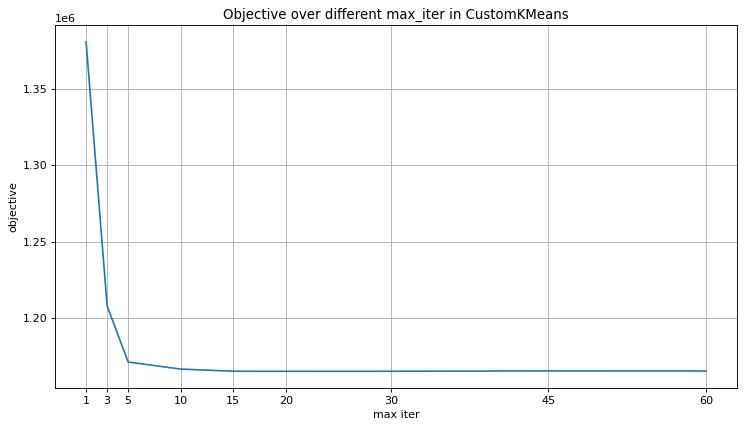

In [8]:
plt.figure(figsize=(11, 6),dpi=80)
obj_custom_max_iter = []
iters = [1,3,5,10,15,20,30,45,60]
for max_iter in iters:
    model = CustomKMeans(n_clusters=10,max_iter =max_iter, random_state=2022)
    model.fit(X)
    obj_custom_max_iter.append(model.objective_)
    
plt.plot(iters,obj_custom_max_iter)
plt.title('Objective over different max_iter in CustomKMeans')
plt.xlabel('max iter')
plt.ylabel('objective')
plt.xticks(iters)
plt.grid(True)
plt.show()

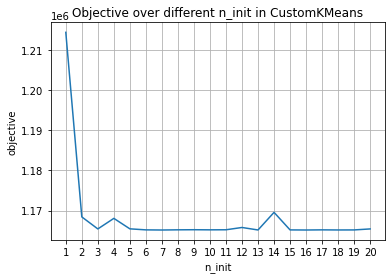

In [42]:
obj_custom_n_init = []
inits = range(1,21)
for n_init in inits:
    model = CustomKMeans(n_clusters=10,n_init=n_init, random_state=2022)
    model.fit(X)
    obj_custom_n_init.append(model.objective_)
    #print(model.objective_)
    
plt.plot(inits,obj_custom_n_init)
plt.title('Objective over different n_init in CustomKMeans')
plt.xlabel('n_init')
plt.ylabel('objective')
plt.grid(True)
plt.xticks(inits)
plt.show()

Let's compare our `objective` with `inertia` from sklearn's `KMeans`:

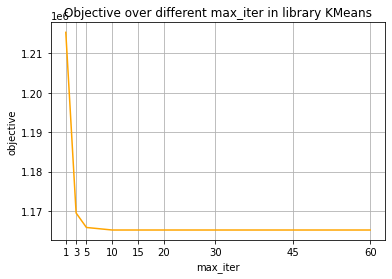

In [10]:
obj_lib_max_iter = []
for max_iter in iters:
    model = KMeans(n_clusters=10,max_iter =max_iter, random_state=2022)
    model.fit(X)
    obj_lib_max_iter.append(model.inertia_)
    
plt.plot(iters,obj_lib_max_iter,c='orange')
plt.title('Objective over different max_iter in library KMeans')
plt.xlabel('max_iter')
plt.ylabel('objective')
plt.xticks(iters)
plt.grid(True)
plt.show()

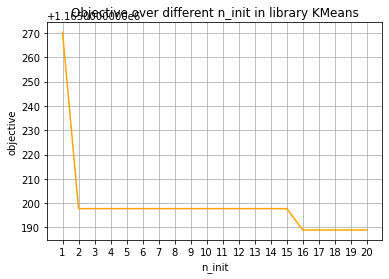

In [11]:
obj_lib_n_init = []
for n_init in inits:
    model = KMeans(n_clusters=10, n_init=n_init, random_state=2022)
    model.fit(X)
    obj_lib_n_init.append(model.inertia_)
    #print(model.inertia_)
    
plt.plot(inits,obj_lib_n_init,c='orange')
plt.title('Objective over different n_init in library KMeans')
plt.xlabel('n_init')
plt.ylabel('objective')
plt.xticks(inits)
plt.grid(True)
plt.show()

We can see that `objective` and `inertia` are fairly in the same range (well, in the sane units, at least), custom `objective` tends to have higher maximal values.

In [12]:
print(f'Objective in CustomKmeans over different max_iter ranges from {np.min(obj_custom_max_iter)} to {np.max(obj_custom_max_iter)}.')
print(f'Objective in CustomKmeans over different n_init ranges from {np.min(obj_custom_n_init)} to {np.max(obj_custom_n_init)}.')
print(f'Inertia in library Kmeans over different max_iter ranges from {np.min(obj_lib_max_iter)} to {np.max(obj_lib_max_iter)}.')
print(f'Inertia in library Kmeans over different n_init ranges from {np.min(obj_lib_n_init)} to {np.max(obj_lib_n_init)}.\n\n')

best_iter = iters[np.argmin(obj_custom_max_iter)]
best_init = inits[np.argmin(obj_custom_n_init)]
print(f'Min value of objective achieved at max_iter = {best_iter}')
print(f'Min value of objective achieved at n_init = {best_init}')

Objective in CustomKmeans over different max_iter ranges from 1165156.9658270434 to 1380702.8663289812.
Objective in CustomKmeans over different n_init ranges from 1165120.162285884 to 1171486.6513730597.
Inertia in library Kmeans over different max_iter ranges from 1165197.7483438086 to 1215335.8235747023.
Inertia in library Kmeans over different n_init ranges from 1165188.9623497347 to 1165270.2273302516.


Min value of objective achieved at max_iter = 20
Min value of objective achieved at n_init = 11


In [13]:
model = CustomKMeans(n_clusters=10,n_init=best_init,max_iter=best_iter, random_state=2022)
model.fit(X)
print(f'Objective with best parameters = {model.objective_}')
#doesn't necessary mean that objective itself is minimal

Objective with best parameters = 1165778.8288688033


My observations are that generally the bigger `mat_iter`, the better. Similar thing can be observed with `n_init`, at least, we can observe it on the plot of library KMeans `inertia`. My custom `objective` shows very weird spiky plots sometimes with unpredictable values. It can be due to a certain degree of randomness, or simply to my mistake in `CustomKMeans`.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [14]:
hierarchical = AgglomerativeClustering(n_clusters=10).fit(X)
hierarchical_labels = hierarchical.labels_

kmeans = KMeans(n_clusters=10).fit(X)
kmeans_labels = kmeans.labels_

In [15]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

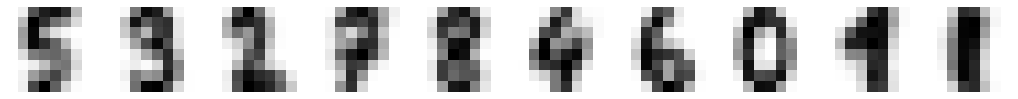

In [16]:
hierarchical_centroids = pd.DataFrame(X).groupby(by=hierarchical_labels).mean().values 
original_hierarchical_centroids = hierarchical_centroids
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image in zip(axes.flatten(), hierarchical_centroids):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

Not all images are clear, but I can definetely see numbers *5, 3, 8, 4, 6, 0, 1*.

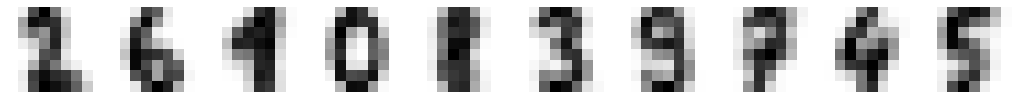

In [17]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
original_kmeans_centroids = kmeans.cluster_centers_
for ax, image in zip(axes.flatten(), kmeans.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

Also not all images are clear, but i can define *0, 3, 6, 5, 1, 4*.

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

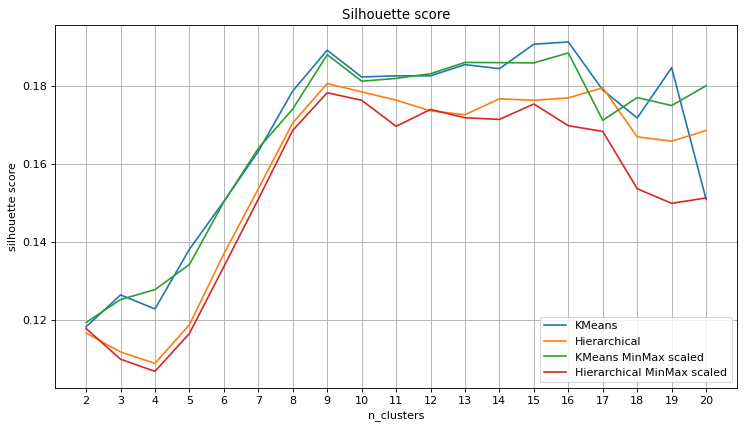

In [18]:
hierarchical_score, kmeans_score, hierarchical_scaled, kmeans_scaled = [],[],[],[]
plt.figure(figsize=(11, 6),dpi=80)
X_scaled = MinMaxScaler().fit_transform(X)
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, random_state=2022)
    kmeans.fit(X)
    kmeans_score.append(silhouette_score(X,kmeans.labels_))
    kmeans.fit(X_scaled)
    kmeans_scaled.append(silhouette_score(X_scaled,kmeans.labels_))
    
    hierarchical = AgglomerativeClustering(n_clusters=n)
    hierarchical.fit(X)
    hierarchical_score.append(silhouette_score(X,hierarchical.labels_))
    hierarchical.fit(X_scaled)
    hierarchical_scaled.append(silhouette_score(X_scaled,hierarchical.labels_))

plt.plot(range(2,21),kmeans_score,label='KMeans')
plt.plot(range(2,21),hierarchical_score,label='Hierarchical')
plt.plot(range(2,21),kmeans_scaled,label='KMeans MinMax scaled')
plt.plot(range(2,21),hierarchical_scaled,label='Hierarchical MinMax scaled')
plt.title('Silhouette score')
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.xticks(range(2,21))
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

`Silhouette score` peaks at `k = 9` in both cases, which is close to our real amount of clusters. Then there's another peak at around 16, 17 clusters.

KMeans generally provides better score.

Scaled data gave worse silhouette scores.

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

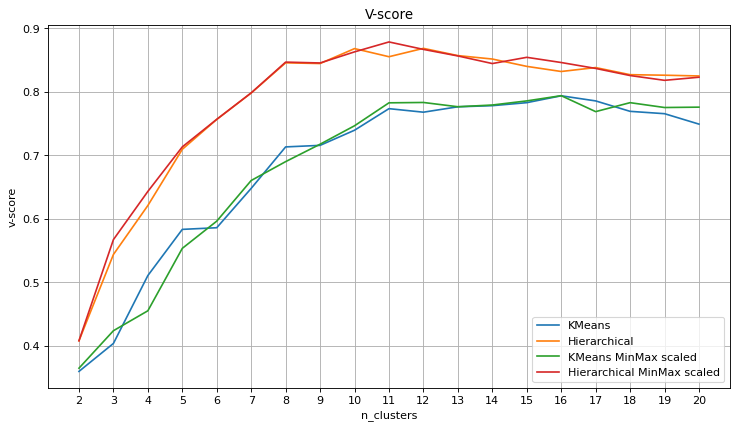

In [19]:
hierarchical_v_score, kmeans_v_score, hierarchical_v_scaled, kmeans_v_scaled = [],[],[],[]
plt.figure(figsize=(11, 6),dpi=80)
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, random_state=2022)
    kmeans.fit(X)
    kmeans_v_score.append(v_measure_score(y,kmeans.labels_))
    kmeans.fit(X_scaled)
    kmeans_v_scaled.append(v_measure_score(y,kmeans.labels_))
    
    hierarchical = AgglomerativeClustering(n_clusters=n)
    hierarchical.fit(X)
    hierarchical_v_score.append(v_measure_score(y,hierarchical.labels_))
    hierarchical.fit(X_scaled)
    hierarchical_v_scaled.append(v_measure_score(y,hierarchical.labels_))

plt.plot(range(2,21),kmeans_v_score,label='KMeans')
plt.plot(range(2,21),hierarchical_v_score,label='Hierarchical')
plt.plot(range(2,21),kmeans_v_scaled,label='KMeans MinMax scaled')
plt.plot(range(2,21),hierarchical_v_scaled,label='Hierarchical MinMax scaled')
plt.title('V-score')
plt.xlabel('n_clusters')
plt.ylabel('v-score')
plt.xticks(range(2,21))
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

On the opposite, Hierarchical clustering gives better score this time.
It peaks at `n = 10,12`, KMeans' v-score peaks at `n = 16`, just as with `silhouette score` 

Scaling doesn't improved v-scores much

In [20]:
print(f'Max v-score in hierarchical is {np.max(hierarchical_v_score)} at n_clusters={np.argmax(hierarchical_v_score) + 2}')
print(f'Max v-score in k-means is {np.max(kmeans_v_score)} at n_clusters={np.argmax(kmeans_v_score) + 2}\n')

print(f'Max silhouette in hierarchical is {np.max(hierarchical_score)} at n_clusters={np.argmax(hierarchical_score) + 2}')
print(f'Max silhouette in k-means is {np.max(kmeans_score)} at n_clusters={np.argmax(kmeans_score) + 2}')

Max v-score in hierarchical is 0.86854875186737 at n_clusters=12
Max v-score in k-means is 0.793880090579392 at n_clusters=16

Max silhouette in hierarchical is 0.18061975703867697 at n_clusters=9
Max silhouette in k-means is 0.19127393703167556 at n_clusters=16


## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

In [21]:
from sklearn.decomposition import TruncatedSVD

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

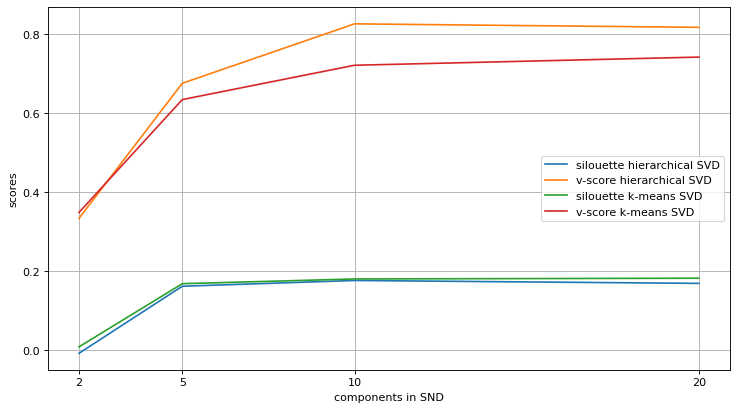

In [22]:
sil_score_h, v_score_h, sil_score_k, v_score_k, = [],[],[],[]
feat = [2,5,10,20]
plt.figure(figsize=(11, 6),dpi=80)
for n in feat:
    svd = TruncatedSVD(n_components=n, random_state=2022)
    reduced_X = svd.fit_transform(X)
    
    kmeans = KMeans(n_clusters=10, random_state=2022).fit(reduced_X)
    v_score_k.append(v_measure_score(y,kmeans.labels_))
    sil_score_k.append(silhouette_score(X,kmeans.labels_))
    
    hierarchical = AgglomerativeClustering(n_clusters=10).fit(reduced_X)
    v_score_h.append(v_measure_score(y,hierarchical.labels_))
    sil_score_h.append(silhouette_score(X,hierarchical.labels_))
    
plt.plot(feat,sil_score_h,label='silouette hierarchical SVD')
plt.plot(feat,v_score_h,label='v-score hierarchical SVD')
plt.plot(feat,sil_score_k,label='silouette k-means SVD')
plt.plot(feat,v_score_k,label='v-score k-means SVD')
plt.xlabel('components in SND')
plt.ylabel('scores')
plt.xticks(feat)
plt.grid(True)
plt.legend(loc='center right')
plt.show()

In [23]:
print(f'Max v-score in hierarchical is {np.max(v_score_h)} at n_components={feat[np.argmax(v_score_h)]}')
print(f'Max v-score in k-means is {np.max(v_score_k)} at n_components={feat[np.argmax(v_score_k)]}\n')

print(f'Max silhouette score in hierarchical is {np.max(sil_score_h)} at n_components={feat[np.argmax(sil_score_h)]}')
print(f'Max silhouette in k-means is {np.max(sil_score_k)} at n_components={feat[np.argmax(sil_score_k)]}')

Max v-score in hierarchical is 0.8259753348813222 at n_components=10
Max v-score in k-means is 0.7418714587123545 at n_components=20

Max silhouette score in hierarchical is 0.1765881132796084 at n_components=10
Max silhouette in k-means is 0.18231617583774082 at n_components=20


We can see that absolute metrics actually decreased after performing SVD and a low number of `n_components` (like 2) produces a very poor result.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

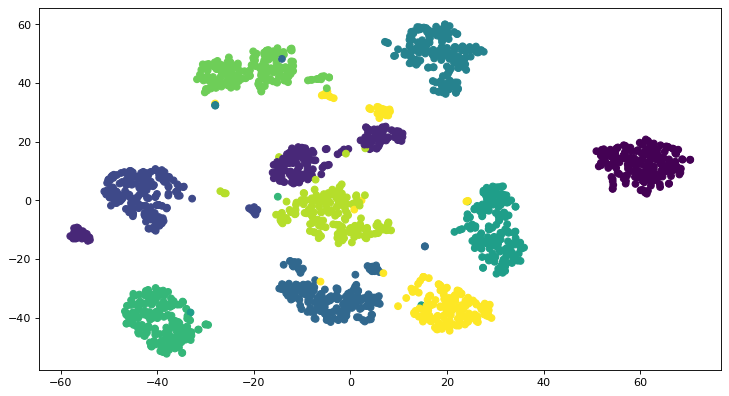

In [24]:
from sklearn.manifold import TSNE

tsne_X = TSNE(n_components=2, random_state=2022).fit_transform(X)
plt.figure(figsize=(11, 6),dpi=80)
plt.scatter(tsne_X[:,0], tsne_X[:,1], c = y);

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [25]:
kmeans = KMeans(n_clusters=10, random_state=2022).fit(tsne_X)
print(f'V-score in K-Means is {v_measure_score(y,kmeans.labels_)}')
print(f'Silhouette score in K-Means is {silhouette_score(X,kmeans.labels_)}')

hierarchical = AgglomerativeClustering(n_clusters=10).fit(tsne_X)
print(f'V-score in Hierarchical is {v_measure_score(y,hierarchical.labels_)}')
print(f'Silhouette score in Hierarchical is {silhouette_score(X,hierarchical.labels_)}')   

V-score in K-Means is 0.9051173490636636
Silhouette score in K-Means is 0.1634947687289514
V-score in Hierarchical is 0.9221901132388951
Silhouette score in Hierarchical is 0.16381192570125694


**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

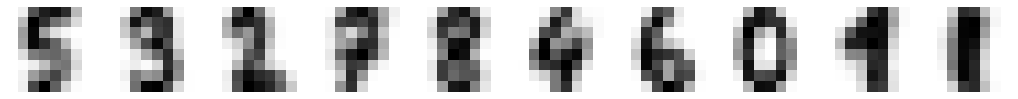

In [26]:
hierarchical_centroids = pd.DataFrame(X).groupby(by=hierarchical_labels).mean().values 

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image in zip(axes.flatten(), hierarchical_centroids):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)
    


BEFORE T-SNE


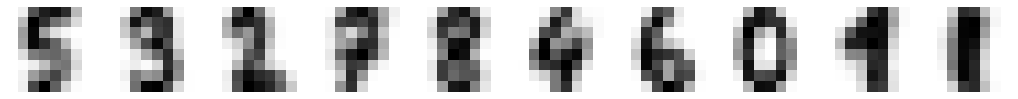

In [27]:
  print('BEFORE T-SNE')
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image in zip(axes.flatten(), original_hierarchical_centroids):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

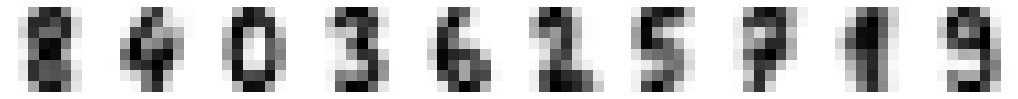

In [28]:
kmeans_centroids = pd.DataFrame(X).groupby(by=kmeans.labels_).mean().values 

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image in zip(axes.flatten(), kmeans_centroids):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)


BEFORE T-SNE


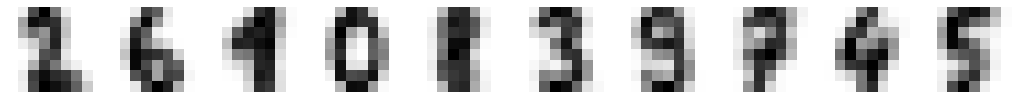

In [29]:
  print('BEFORE T-SNE')
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image in zip(axes.flatten(), original_kmeans_centroids):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

Numbers *8, 1* are now clearer with K-Means clusterisation. with hierarchical nothing reaaly changed.

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

These algorithms perform differently on different datasets, but generally K-means works better on bigger datasets with sort of sherical cluster shapes. 

When it comes to our spefcific problem, thoughout the notebook K-means gave us better *v-score*, while Hierarchical clustering gave us better *silhouette score*, even after hyperparameter tunings and dimensionality reductions/

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

When we have a new data point, we can compare distances to 
* cluster centroids
* closest point in each cluster
* farthest point in each cluster

And compare clustering quality with silhouette score, for example.

**(0.5 points)** Does dimensionality reduction improve clustering results?

Dimensionality reduction helps us escape *the curse of dimensionality*, a situation where the more features we have, the esponentially more samples we need to correctly train our estimator, and the amount of samples is usually limited. In short, *the curse of dimensionality* is a big problem that complicates machine learning processes. And the most obvious way of dealing with it is to reduce dimensions.

Also, dimensionality reduction makes computation easier, since out algorythms have less data to operate with. This way we can improve fit time and make training and prediction significantly faster.

Generally, I would say that dimensionality reduction improves clustering resilts.

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

We can visualize the results and see which dimensionaluty reduction technique separates the clusters better. 

We can calculate different clusterisation metrics on our high-dimensional data and then compare them to metrics we got after dimensionality reduction to see it metrics changed for better or for worse. If metrics decreased siggnificantly, chances are DR didn't preserve enough important information about our dataset OR it was just done wrong, which led to poorer clusterisation.


**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [30]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [31]:
X.shape

(70000, 784)

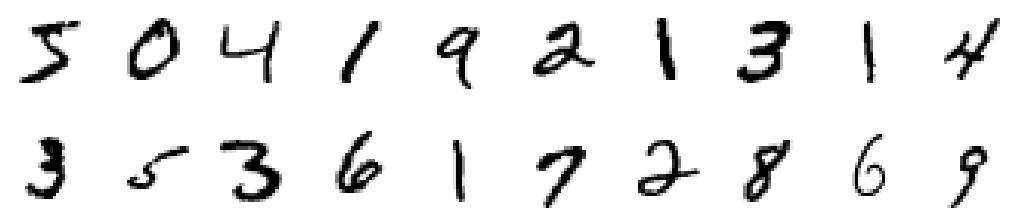

In [32]:
_, axes = plt.subplots(nrows=2, ncols=10, figsize=(18, 4))
for ax, image, label in zip(axes.flatten(), X.values, y.values):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)
    ax.set_label(label)

In [33]:
kmeans = KMeans(n_clusters=10, n_init=8, random_state=42)
kmeans.fit(X)
print(f'V-score is {v_measure_score(y,kmeans.labels_)}')
print(f'Silhouette score is {silhouette_score(X.values,kmeans.labels_)}')

C:\Users\Masha\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


V-score is 0.4997437873174721
Silhouette score is 0.05869201052848778


K-means on all data

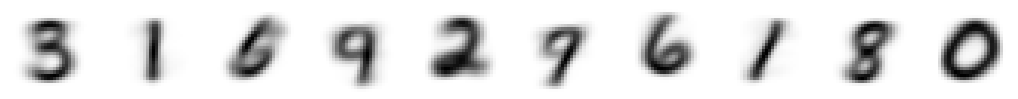

In [34]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image in zip(axes.flatten(), kmeans.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)

We can see that simple K-means without dimensionality reduction didn't work so well. Centroids turned our very similar - I can see at least three of them looking like 9.

We should try other dimensionality reduction below.

In [35]:
from sklearn.model_selection import train_test_split

mnist_leave_out,mnist_sample, mnist_labels_leave_out, mnist_labels_sample, = train_test_split( X, y, test_size=0.12, random_state=2022)

tsne_mnist = TSNE(n_components=3, random_state=2022).fit_transform(mnist_sample.values)

In [36]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(mnist_sample.values)
print(f'V-score is {v_measure_score(mnist_labels_sample,kmeans.labels_)}')
print(f'Silhouette score is {silhouette_score(mnist_sample.values,kmeans.labels_)}')

V-score is 0.5055772920984146
Silhouette score is 0.05861736564160954


K-means on data reducted by t-SNE to 3 components.

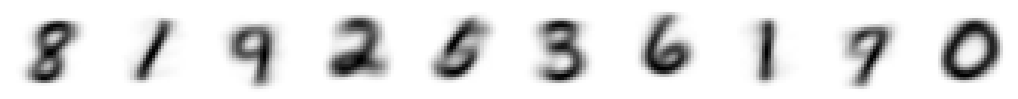

In [37]:
kmeans_centroids = pd.DataFrame(mnist_sample.values).groupby(by=kmeans.labels_).mean().values

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(18, 4))
for ax, image in zip(axes.flatten(), kmeans_centroids):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)

Sorry, didn't have more time to experiment with MNIST.

Situation after DR slightly inproved, but 1 and 7, 4 and 9 are still confused a lot.